# Title : Malicious Attack Detection using NF-UNSW-NB15 dataset



# Problem Definition

We would like to detect malicious attacks from network packets. Our goal is to use our trained model to classify an incoming packet to be benign or malicious.

# Dataset

Our dataset is NF-UNSW-NB15 dataset from kaggle. (https://www.kaggle.com/datasets/dhoogla/nfunswnb15v2?select=NF-UNSW-NB15-V2.parquet) This is one dataset in the NFV2-collection by the university of Queensland aimed at standardizing network-security datasets to achieve interoperability and larger analyses.
The targets of the dataset are benign (account for 96.22%) and malicious. The attack type of malicious contains Exploits, Fuzzers, Reconnaissance, etc. The total number of instances is about 2M.


# Model Description

## Preprocessing

1. We expand our features by transforming some categorical columns as dummy variables.

2. Then we use MinMaxScaler to normalize the data because the value ranges between columns are large.


Number of features : 107 (originally 43)

Number of instances : 2M

## Model

We have mainly two types of model. One is auto-encoder based, the others are non auto-encoder based models. The models of non auto-encoder are Logistic regression, Decision Tree, Random Forest and Neural Network. We randomly select 5000 anomaly and 5000 normal data to evaluate our models. However, for autoencoder, we use the remaining (how much)normal data. For other models, we undersample the benign class to train on about 70000 instances for both classes.

1. Autoencoder

We use autoencoder for anomaly detection because we want to model what a normal packet looks like. We train a network that reduce its input into 4  dimension (latent space) and reconstruct back to 107 dimension. We expect abnormal data to reconstruct poorly since the model has not seen them before, thus losses are higher for anomaly. Then we can decide a threshold to classify normal and anomaly packet.

2. Logistic Regression

We use logistic regression for anomaly detection because logistic regression is a statistical model commonly used to analyze binary classification problems. It is specifically designed to predict the probability of an event occurring, given certain input variables or features. The binary classification problem refers to a scenario where the outcome variable can take only two possible values, typically represented as 0 and 1. Overall, logistic regression is well-suited for binary classification problems due to its ability to model probabilities, its flexibility in capturing the relationship between variables and outcomes, and its interpretability in terms of log-odds and decision boundaries.

3. Decision Tree

We use decision tree for anomaly detection because decision tree is a popular machine learning algorithm used for both classification and regression tasks. It is particularly well-suited for binary classification problems, where the goal is to assign instances to one of two classes. Besides, we set the max_depth of decision tree is 3, which prevents from overfitting.

4. Random Forest

We use random forest for anomaly detection because random forest is well-suited for binary classification problems due to its ability to handle binary outcomes. It is an ensemble learning method that combines multiple decision trees to make predictions. Each decision tree in the forest is trained on a different subset of the data, and the final prediction is determined by aggregating the predictions of all the individual trees. Besides, we set the max_depth of random forest is 3, which prevents from overfitting.

5. Neural Network

We use neural network for anomaly detection because neural network can be effectively used for binary classification problems due to its ability to model complex relationships between input data and its corresponding classes. Also, neural network can learn complex, non-linear relationships in the data, adapt to a wide range of input features, and generalize well to new instances. We train a network that reduce its input into 1 dimension (latent space). Then we can classify normal and anomaly packet through the neural network model.


# Analysis codes

## Preprocessing

In [ ]:
!pip install urllib3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df = pd.read_parquet('https://drive.google.com/uc?id=1m04SRdFo34QnHDiBh1A2ymL_iT3brQYJ')

In [ ]:
labels = df[['Label','Attack']]
df.drop(columns=['Label','Attack'],inplace=True)

In [ ]:
# dummy :TCP_FLAGS CLIENT_TCP_FLAGS SERVER_TCP_FLAGS MIN_TTL MAX_TTL FTP_COMMAND_RET_CODE
dummy = ['TCP_FLAGS','CLIENT_TCP_FLAGS','SERVER_TCP_FLAGS','MIN_TTL','MAX_TTL','FTP_COMMAND_RET_CODE']

In [ ]:
df = pd.get_dummies(data=df,columns=dummy,prefix_sep = '__')

In [ ]:
# 出現少於十次的dummy variable 則刪除(降低一個維度的運算複雜度)
sparse = []
cnt = 0
for col in df.columns:

  if '__' in col and df[col].sum() < 10:
    sparse.append(col)
    cnt += 1
sparse

['TCP_FLAGS__4',
 'TCP_FLAGS__21',
 'TCP_FLAGS__23',
 'TCP_FLAGS__31',
 'CLIENT_TCP_FLAGS__4',
 'CLIENT_TCP_FLAGS__23',
 'CLIENT_TCP_FLAGS__30',
 'CLIENT_TCP_FLAGS__31',
 'SERVER_TCP_FLAGS__2',
 'SERVER_TCP_FLAGS__20',
 'SERVER_TCP_FLAGS__22',
 'SERVER_TCP_FLAGS__23',
 'SERVER_TCP_FLAGS__30',
 'SERVER_TCP_FLAGS__31',
 'MIN_TTL__30',
 'MIN_TTL__32',
 'MIN_TTL__255',
 'MAX_TTL__60',
 'FTP_COMMAND_RET_CODE__350.0',
 'FTP_COMMAND_RET_CODE__501.0']

In [ ]:
df.drop(columns=sparse,inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# 標準化 因各欄位值愈差很多
cols = df.columns
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(df))
df.columns = cols

In [ ]:
# 再添加回Label(不參與標準化)
df['Label'] = labels['Label']

In [ ]:
df.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,FLOW_DURATION_MILLISECONDS,DURATION_IN,...,FTP_COMMAND_RET_CODE__220.0,FTP_COMMAND_RET_CODE__221.0,FTP_COMMAND_RET_CODE__226.0,FTP_COMMAND_RET_CODE__227.0,FTP_COMMAND_RET_CODE__229.0,FTP_COMMAND_RET_CODE__230.0,FTP_COMMAND_RET_CODE__250.0,FTP_COMMAND_RET_CODE__257.0,FTP_COMMAND_RET_CODE__331.0,Label
0,0.019913,0.00032,0.023529,0.004032,2.645379e-07,0.000000,0.000013,0.000271,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,0.019913,0.00032,0.023529,0.004032,8.597483e-06,0.000175,0.000032,0.000632,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,0.019913,0.00032,0.023529,0.004032,1.587228e-05,0.000349,0.000051,0.000993,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,0.019913,0.00032,0.023529,0.004032,2.314707e-05,0.000524,0.000072,0.001354,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.019913,0.00032,0.023529,0.004032,3.405926e-05,0.000786,0.000101,0.001896,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [ ]:
# 準備 10000 筆 測試資料 normal anomaly 各5000筆
# Autoencoder 輸入 : Test資料外的normal 共 1906666 筆
# Autoencoder 輸出 : 同輸入

# 其他模型輸入 : 190666 筆 normal Downsample 到 70079筆 normal
#                                           + 70079筆 anomaly
#                                          共 140158筆

test_size = 5000

anomaly = df[df['Label'] == 1]
import random
# 設相同的random seed 確保每次亂數相同
random.seed(42)

anomaly_idx = (random.sample([s for s in range(len(anomaly))],5000))
anomaly.index = np.arange(len(anomaly))
print(anomaly_idx[:5])
test_set_anomaly = anomaly[anomaly.index.isin(anomaly_idx)]

normal = df[df['Label'] == 0]
normal.index = np.arange(len(normal))
normal_idx = (random.sample([s for s in range(len(normal))],5000))
print(normal_idx[:5])

test_set_normal = normal[normal.index.isin(normal_idx)]

X_test = pd.concat([test_set_anomaly,test_set_normal])
X_test['Label'].value_counts()

Y_test = X_test['Label']
X_test.drop(columns='Label',inplace=True)

[14592, 3278, 36048, 32098, 29256]
[102940, 768300, 462889, 1270776, 1505430]


In [ ]:
# Downsample 過程
train_benign = normal[~normal.index.isin(normal_idx)]
train_anomaly = anomaly[~anomaly.index.isin(anomaly_idx)]

train_benign.index = np.arange(len(train_benign))

normal_idx_mldl = (random.sample([s for s in range(len(train_benign))],len(train_anomaly)))
train_benign_ml = train_benign[train_benign.index.isin(normal_idx_mldl)]
print(len(normal_idx_mldl))

70079


In [ ]:
train_concat = pd.concat([train_benign_ml,train_anomaly])
Y_train_mldl = train_concat['Label']
X_train_mldl = train_concat.drop(columns='Label')

In [ ]:
print(Y_train_mldl.shape)
print(X_train_mldl.shape)

(140158,)
(140158, 107)


## AutoEncoder

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
Y_train_encoder = train_benign['Label']
X_train_encoder = train_benign.drop(columns='Label')

In [ ]:
X_train_encoder.shape

(1906666, 107)

In [ ]:
input_dim = X_train_encoder.shape[1]  # Dimension of input data (107)

# Encoder
encoder_input = keras.Input(shape=(input_dim,))
encoder_output = layers.Dense(64, activation="relu")(encoder_input)
encoder_output = layers.Dense(32, activation="relu")(encoder_output)
encoder_output = layers.Dense(16, activation="relu")(encoder_output)
encoder_output = layers.Dense(8, activation="relu")(encoder_output)
# latent space (4D)
decoder_output = layers.Dense(4, activation="relu")(encoder_output)
decoder_output = layers.Dense(8, activation="relu")(decoder_output)
decoder_output = layers.Dense(16, activation="relu")(decoder_output)

# Decoder
decoder_output = layers.Dense(32, activation="relu")(decoder_output)
decoder_output = layers.Dense(64, activation="relu")(decoder_output)
decoder_output = layers.Dense(input_dim, activation="sigmoid")(decoder_output)

# Autoencoder model
autoencoder = keras.Model(encoder_input, decoder_output)


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)
autoencoder.compile(optimizer="adam", loss='mse')
# 訓練3輪之後都沒有進步0.0001的話就提早停止訓練
callback = keras.callbacks.EarlyStopping(
  monitor = 'val_loss', # monitor val_loss when training
  min_delta = 0.0001, # minimum change of 'monitor' to qualify as an improvementness.
  patience = 3 # epochs with no improvement after which training will be stopped.
)


In [ ]:
history = autoencoder.fit(X_train_encoder, X_train_encoder, epochs=20, batch_size=128, validation_split=0.2,callbacks=[callback])

Epoch 1/20
11917/11917 [==============================] - 50s 4ms/step - loss: 0.0066 - val_loss: 0.0047
Epoch 2/20
11917/11917 [==============================] - 55s 5ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 3/20
11917/11917 [==============================] - 52s 4ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 4/20
11917/11917 [==============================] - 51s 4ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 5/20
11917/11917 [==============================] - 54s 5ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 6/20
11917/11917 [==============================] - 44s 4ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 7/20
11917/11917 [==============================] - 44s 4ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 8/20
11917/11917 [==============================] - 43s 4ms/step - loss: 0.0026 - val_loss: 0.0027


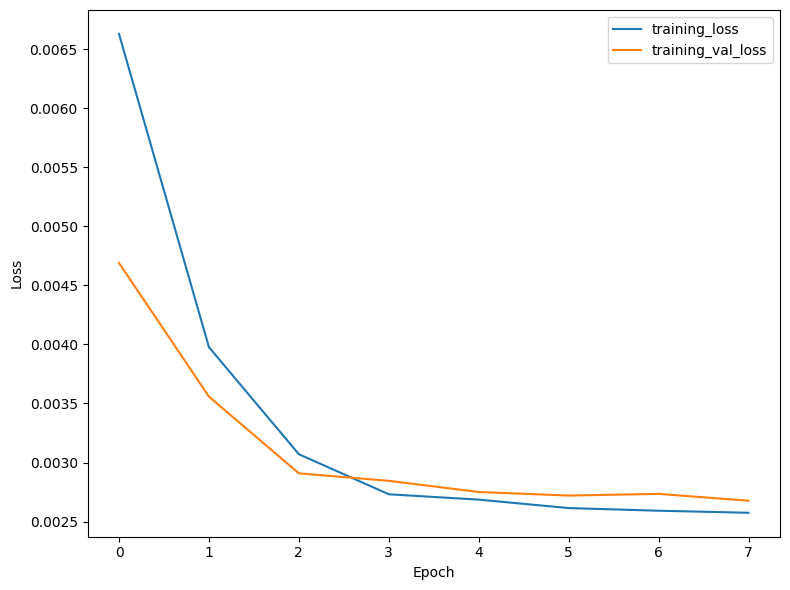

In [ ]:
import matplotlib.pyplot as plt

model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

ax.plot(np.arange(0, num_epochs), model_history["loss"],
        label="training_loss")
ax.plot(np.arange(0, num_epochs), model_history["val_loss"],
        label="training_val_loss")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Since training from scratch may not yield the best autoencoder model
# We tried several time and provide the best model parameters in h5 format
import urllib.request

urllib.request.urlretrieve('https://drive.google.com/uc?id=1OIuLnoam5z8IqrT4lUm2h-CxXIRGX848&authuser=0&export=download', 'model.h5')

('model.h5', <http.client.HTTPMessage at 0x7fa9aa02bb80>)

In [ ]:
# Since training from scratch may not yield the best autoencoder model
# We tried several time and provide the best model parameters in h5 format
from pathlib import Path
if Path('model.h5').exists():
  from keras.models import load_model
  autoencoder = load_model('model.h5')

In [ ]:
if 'Label' in X_test.columns:
  label_test = X_test['Label']
  X_test.drop(columns='Label',inplace=True)
output= autoencoder.predict(X_test)

313/313 [==============================] - 1s 1ms/step


In [ ]:
# 輸入與輸出相減的loss (前5000筆為anomaly)
np.square(X_test - output).sum(axis=1)[:(test_size)].sum()

17347.835636037336

In [ ]:
# 輸入與輸出相減的loss (後5000筆為normal)
np.square(X_test - output).sum(axis=1)[(test_size):].sum()

431.9817574875335

In [ ]:
normal_error = np.square(X_test - output).sum(axis=1)[:test_size]

In [ ]:
attack_error = np.square(X_test - output).sum(axis=1)[test_size:]

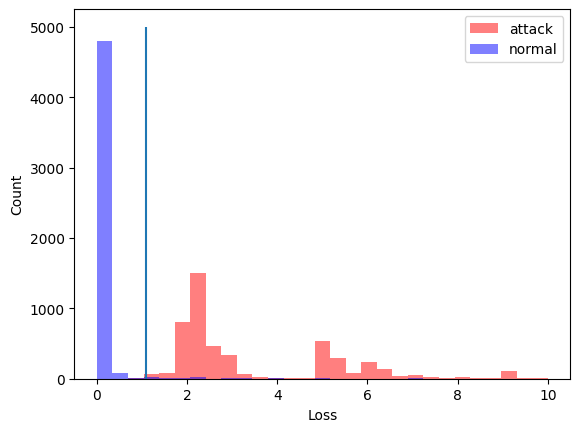

In [ ]:
from matplotlib import pyplot

bins = np.linspace(0, 10, 30)

pyplot.hist(normal_error, bins, alpha=0.5, label='attack',color='red')
pyplot.hist(attack_error, bins, alpha=0.5, label='normal',color='blue')
pyplot.xlabel('Loss')
pyplot.ylabel('Count')
pyplot.vlines(1.08,0,5000)
pyplot.legend(loc='upper right')
pyplot.show()

In [ ]:
# 尋找最適當的threshold 將normal 和 abnormal分的最開
from sklearn.metrics import confusion_matrix
temp = []
for i in np.arange(0.8,2,0.01):
  result = pd.DataFrame(normal_error)
  result.columns = ['Predicted']
  result['Actual'] = 0
  result2 = pd.DataFrame(attack_error)
  result2.columns = ['Predicted']
  result2['Actual'] = 1
  result_concat = pd.concat([result,result2])
  i = round(i,2)
  result_concat['Predicted_Result'] = result_concat['Predicted'].apply(lambda x:0 if x>i else 1)
  predicted_result = result_concat['Predicted_Result'].to_list()
  actual = result_concat['Actual'].to_list()
  temp.append([i,(confusion_matrix(actual,predicted_result)[0][0] +
              confusion_matrix(actual,predicted_result)[1][1]) /10000])
print(max(temp,key=lambda x:x[1]))

[1.08, 0.9905]


In [ ]:
threshold = 1.08

In [ ]:
result = pd.DataFrame(normal_error)
result.columns = ['Predicted']
result['Actual'] = 0

In [ ]:
result2 = pd.DataFrame(attack_error)
result2.columns = ['Predicted']
result2['Actual'] = 1

In [ ]:
result_concat = pd.concat([result,result2])

In [ ]:
result_concat['Predicted_Result'] = result_concat['Predicted'].apply(lambda x:0 if x>threshold else 1)

In [ ]:
predicted_result = result_concat['Predicted_Result'].to_list()
actual = result_concat['Actual'].to_list()

In [ ]:
cm = confusion_matrix(actual,predicted_result)
print(cm)
precision_autoencoder = cm[0][0] /(cm[0][0] + cm[0][1])
recall_autoencoder = cm[0][0] /(cm[0][0] + cm[1][0])
f1_autoencoder = (2 * precision_autoencoder * recall_autoencoder) / (precision_autoencoder + recall_autoencoder)

print(f"Precision : {precision_autoencoder}")
print(f"Recall    : {recall_autoencoder}")
print(f"Accuracy  : {(cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])}")
print(f"F1-score  : {f1_autoencoder}")

[[4991    9]
 [  86 4914]]
Precision : 0.9982
Recall    : 0.9830608627142013
Accuracy  : 0.9905
F1-score  : 0.9905725910489234


In [ ]:
# 將參數儲存留作後續使用
#autoencoder.save('model.h5')

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
X_train_mldl.shape

(140158, 107)

In [ ]:
# 建立Logistic Regression模型
model_logistic_regreesion = LogisticRegression()

In [ ]:
# 在訓練集上訓練模型
model_logistic_regreesion.fit(X_train_mldl, Y_train_mldl)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# 在測試集上進行預測
y_predict = model_logistic_regreesion.predict(X_test)

In [ ]:
# 評估模型
from sklearn.metrics import confusion_matrix

cm_logistic_regression = confusion_matrix(Y_test.values, y_predict)
print(cm_logistic_regression)
precision_logistic_regression = cm_logistic_regression[0][0] /(cm_logistic_regression[0][0] + cm_logistic_regression[0][1])
recall_logistic_regression = cm_logistic_regression[0][0] /(cm_logistic_regression[0][0] + cm_logistic_regression[1][0])
f1_logistic_regression = (2 * precision_logistic_regression * recall_logistic_regression) / (precision_logistic_regression + recall_logistic_regression)

print(f"Precision : {precision_logistic_regression}")
print(f"Recall    : {recall_logistic_regression}")
print(f"Accuracy  : {(cm_logistic_regression[0][0] + cm_logistic_regression[1][1]) / (cm_logistic_regression[0][0] + cm_logistic_regression[0][1] + cm_logistic_regression[1][0] + cm_logistic_regression[1][1])}")
print(f"F1-score  : {f1_logistic_regression}")

[[4975   25]
 [   3 4997]]
Precision : 0.995
Recall    : 0.9993973483326637
Accuracy  : 0.9972
F1-score  : 0.9971938264181198


In [ ]:
# print the intercept and coefficients
print('Intercept is ', model_logistic_regreesion.intercept_)
print('coefficients  is ', model_logistic_regreesion.coef_)

Intercept is  [0.91859094]
coefficients  is  [[-3.87158346e-01 -9.95111528e-01  1.30152246e+00 -2.95592157e-01
   1.94374499e-01  2.71333968e-01  1.08794855e-01  2.70600613e-01
  -7.16438986e-01 -5.49879452e-01  2.36385445e-01  6.20414871e-01
   7.32569349e-01  1.88391334e-01  6.20414871e-01  1.39012628e-03
  -8.06622703e-03  2.02162407e-01  2.72659654e-01  1.03449542e-01
   1.21104996e-01 -1.01101412e+00  1.17017575e+00  5.33238294e-01
   6.00045767e-02  6.35853756e-01  1.17782360e-01  2.07004605e-01
  -6.25117047e+00 -1.98289769e+00 -2.27124045e-01 -2.16717473e-01
  -1.37604130e+00 -4.87277688e-02  8.06267167e-03  7.86486555e-01
  -2.54659128e+00  5.55738114e-01  2.03770613e-01  2.48551495e-01
   5.87663547e-04 -6.07362773e-01  5.08460324e-01  4.37662429e-01
   5.43364085e-01  7.90805267e-01 -4.80771261e-01 -3.90774837e-01
   7.86486555e-01 -1.13501319e+00  5.57963714e-01  1.69121456e-01
  -1.03393253e+00 -2.66795690e-01 -5.91753532e-01  1.17685487e-01
   4.35120353e-01  5.78329717e-

In [ ]:
# print with feature name
print('label = ')
for c,f in zip(model_logistic_regreesion.coef_[0], X_train_mldl.columns):
  print(' {0:+} * {1}'.format(c, f))
print('', model_logistic_regreesion.intercept_[0])

label = 
 -0.387158345788914 * L4_SRC_PORT
 -0.9951115279752712 * L4_DST_PORT
 +1.301522459739891 * PROTOCOL
 -0.2955921568497237 * L7_PROTO
 +0.19437449903487336 * IN_BYTES
 +0.2713339684360103 * IN_PKTS
 +0.1087948547966906 * OUT_BYTES
 +0.27060061279533504 * OUT_PKTS
 -0.7164389856524412 * FLOW_DURATION_MILLISECONDS
 -0.5498794521856769 * DURATION_IN
 +0.2363854447656072 * DURATION_OUT
 +0.6204148707594973 * LONGEST_FLOW_PKT
 +0.732569349331126 * SHORTEST_FLOW_PKT
 +0.18839133449178008 * MIN_IP_PKT_LEN
 +0.6204148707594973 * MAX_IP_PKT_LEN
 +0.0013901262819893774 * SRC_TO_DST_SECOND_BYTES
 -0.008066227029363927 * DST_TO_SRC_SECOND_BYTES
 +0.20216240734438892 * RETRANSMITTED_IN_BYTES
 +0.2726596541803465 * RETRANSMITTED_IN_PKTS
 +0.10344954229729157 * RETRANSMITTED_OUT_BYTES
 +0.1211049963462521 * RETRANSMITTED_OUT_PKTS
 -1.0110141231266037 * SRC_TO_DST_AVG_THROUGHPUT
 +1.1701757488446631 * DST_TO_SRC_AVG_THROUGHPUT
 +0.533238294410143 * NUM_PKTS_UP_TO_128_BYTES
 +0.06000457668822584

## Decision Tree

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [ ]:
X_train_mldl.shape

(140158, 107)

In [ ]:
# 建立決策樹模型
model_decision_tree = DecisionTreeClassifier(max_depth=3)

In [ ]:
# 在訓練集上訓練模型
model_decision_tree.fit(X_train_mldl, Y_train_mldl)

DecisionTreeClassifier(max_depth=3)

In [ ]:
# 在測試集上進行預測
y_predict = model_decision_tree.predict(X_test)

In [ ]:
# 評估模型
from sklearn.metrics import confusion_matrix

cm_decision_tree = confusion_matrix(Y_test.values, y_predict)
print(cm_decision_tree)
precision_decision_tree = cm_decision_tree[0][0] /(cm_decision_tree[0][0] + cm_decision_tree[0][1])
recall_decision_tree = cm_decision_tree[0][0] /(cm_decision_tree[0][0] + cm_decision_tree[1][0])
f1_decision_tree = (2 * precision_decision_tree * recall_decision_tree) / (precision_decision_tree + recall_decision_tree)

print(f"Precision : {precision_decision_tree}")
print(f"Recall    : {recall_decision_tree}")
print(f"Accuracy  : {(cm_decision_tree[0][0] + cm_decision_tree[1][1]) / (cm_decision_tree[0][0] + cm_decision_tree[0][1] + cm_decision_tree[1][0] + cm_decision_tree[1][1])}")
print(f"F1-score  : {f1_decision_tree}")

[[4968   32]
 [   0 5000]]
Precision : 0.9936
Recall    : 1.0
Accuracy  : 0.9968
F1-score  : 0.9967897271268058


In [ ]:
# 顯示特徵的重要程度
print('Importances: ', model_decision_tree.feature_importances_)

Importances:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.60592912e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.93817717e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000000

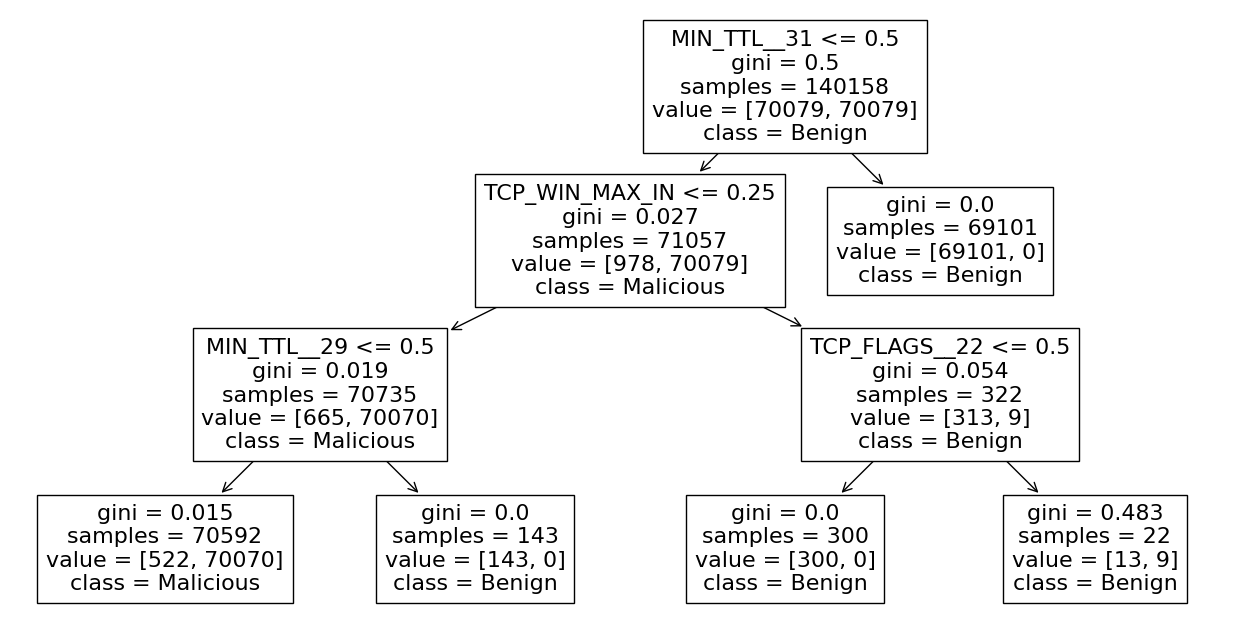

In [ ]:
# using tree to show decisions
plt.figure(figsize = (16, 8))
tree.plot_tree(model_decision_tree, feature_names=X_test.columns, class_names=['Benign','Malicious'])
plt.show()

In [ ]:
# using text to show decisions
r = tree.export_text(model_decision_tree)
print(r)

|--- feature_72 <= 0.50
|   |--- feature_28 <= 0.25
|   |   |--- feature_71 <= 0.50
|   |   |   |--- class: 1
|   |   |--- feature_71 >  0.50
|   |   |   |--- class: 0
|   |--- feature_28 >  0.25
|   |   |--- feature_42 <= 0.50
|   |   |   |--- class: 0
|   |   |--- feature_42 >  0.50
|   |   |   |--- class: 0
|--- feature_72 >  0.50
|   |--- class: 0



## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
X_train_mldl.shape

(140158, 107)

In [ ]:
# 建立隨機森林模型
model_random_forest = RandomForestClassifier(max_depth = 3)

In [ ]:
# 在訓練集上訓練模型
model_random_forest.fit(X_train_mldl, Y_train_mldl)

RandomForestClassifier(max_depth=3)

In [ ]:
# 在測試集上進行預測
y_predict = model_random_forest.predict(X_test)

In [ ]:
# 評估模型
from sklearn.metrics import confusion_matrix

cm_random_forest = confusion_matrix(Y_test.values, y_predict)
print(cm_random_forest)
precision_random_forest = cm_random_forest[0][0] /(cm_random_forest[0][0] + cm_random_forest[0][1])
recall_random_forest = cm_random_forest[0][0] /(cm_random_forest[0][0] + cm_random_forest[1][0])
f1_random_forest = (2 * precision_random_forest * recall_random_forest) / (precision_random_forest + recall_random_forest)

print(f"Precision : {precision_random_forest}")
print(f"Recall    : {recall_random_forest}")
print(f"Accuracy  : {(cm_random_forest[0][0] + cm_random_forest[1][1]) / (cm_random_forest[0][0] + cm_random_forest[0][1] + cm_random_forest[1][0] + cm_random_forest[1][1])}")
print(f"F1-score  : {f1_random_forest}")

[[4952   48]
 [   4 4996]]
Precision : 0.9904
Recall    : 0.9991928974979822
Accuracy  : 0.9948
F1-score  : 0.9947770188830856


In [ ]:
# 顯示特徵的重要程度
print('Importances: ', model_random_forest.feature_importances_)

Importances:  [1.15391383e-05 1.05086244e-02 4.14758289e-03 1.15362078e-03
 4.07762381e-04 9.08104352e-04 1.82876354e-02 1.86096579e-02
 2.09742716e-05 6.25268229e-09 0.00000000e+00 4.32325893e-03
 4.79629059e-02 1.56677817e-01 3.24845101e-03 2.60194656e-06
 3.83530215e-07 6.21040726e-03 3.62600307e-03 9.35607396e-03
 9.48096614e-03 1.23703433e-03 1.37737930e-02 3.81441850e-02
 5.97443127e-04 6.98215562e-04 2.61494630e-06 2.66810649e-03
 1.41448246e-02 4.86742121e-02 1.38758296e-05 4.50745284e-04
 8.69452545e-04 1.30790900e-03 2.98871178e-05 7.34839763e-04
 1.20687358e-04 0.00000000e+00 0.00000000e+00 1.26896339e-04
 1.37447627e-02 0.00000000e+00 5.04406326e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.76636011e-03 0.00000000e+00
 2.21030491e-03 7.80913614e-05 0.00000000e+00 0.00000000e+00
 2.33368665e-04 1.33384590e-02 2.88475893e-07 4.80292146e-07
 3.61201238e-03 0.00000000e+00 0.00000000e+00 4.13462668e-03
 0.00000000e+00 1.53091209e-03 6.39232842e-04 1.31979664e-04
 5.1663007

## Neural Network

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
X_train_mldl.shape

(140158, 107)

In [ ]:
# Normalize
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train_mldl))

In [ ]:
# 建立神經網路模型
model_neural_network = keras.Sequential([
  normalizer,
  layers.Flatten(input_shape=np.array(X_train_mldl).shape), # 將輸入攤平成一維向量
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')
])

In [ ]:
# 編譯模型
model_neural_network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# 查看模型
model_neural_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 107)              215       
 n)                                                              
                                                                 
 flatten (Flatten)           (None, 107)               0         
                                                                 
 dense (Dense)               (None, 256)               27648     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [ ]:
# 訓練3輪之後都沒有進步0.0005的話就提早停止訓練
callback = keras.callbacks.EarlyStopping(
  monitor = 'val_accuracy', # monitor val_accuracy when training
  min_delta = 0.0005, # minimum change of 'monitor' to qualify as an improvementness.
  patience = 3 # epochs with no improvement after which training will be stopped.
)

# 訓練模型
history_neural_network = model_neural_network.fit(
  np.array(X_train_mldl),
  np.array(Y_train_mldl).astype(int),
  epochs = 20,
  batch_size = 256,
  shuffle = True,
  callbacks = [callback],
  validation_split = 0.2
)

Epoch 1/20
438/438 [==============================] - 6s 9ms/step - loss: 0.0432 - accuracy: 0.9903 - val_loss: 0.0060 - val_accuracy: 0.9996
Epoch 2/20
438/438 [==============================] - 4s 9ms/step - loss: 0.0225 - accuracy: 0.9956 - val_loss: 0.0073 - val_accuracy: 0.9993
Epoch 3/20
438/438 [==============================] - 4s 9ms/step - loss: 0.0201 - accuracy: 0.9959 - val_loss: 0.0050 - val_accuracy: 0.9997
Epoch 4/20
438/438 [==============================] - 4s 9ms/step - loss: 0.0195 - accuracy: 0.9960 - val_loss: 0.0108 - val_accuracy: 0.9995


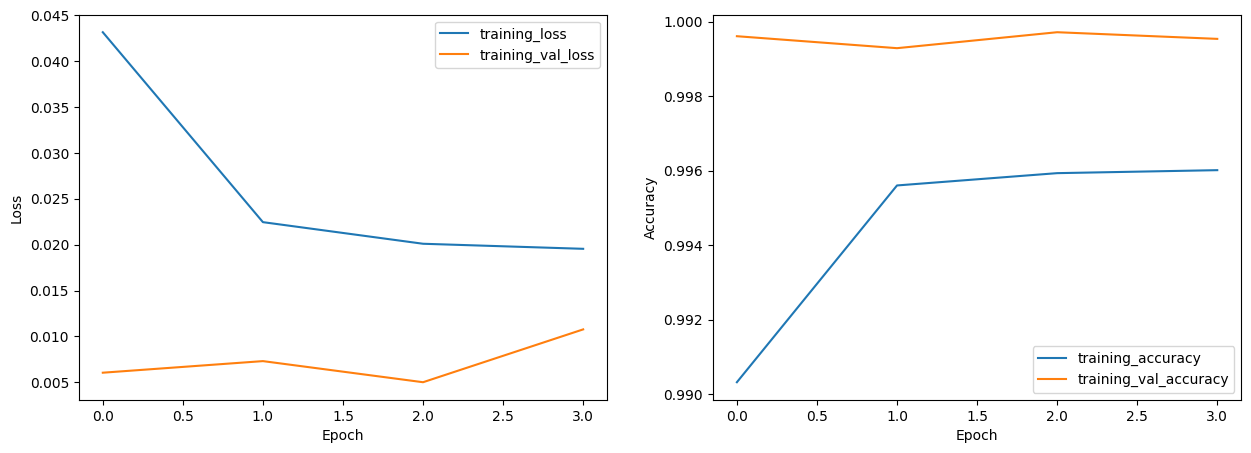

In [ ]:
# 畫圖展示Training時的Loss和Accuracy
def plot_loss_and_accuracy(history):
  plt.figure(figsize=(15, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='training_loss')
  plt.plot(history.history['val_loss'], label='training_val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='training_accuracy')
  plt.plot(history.history['val_accuracy'], label='training_val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

plot_loss_and_accuracy(history_neural_network)

In [ ]:
# 在測試集上進行預測
y_predict = model_neural_network.predict(np.array(X_test))

313/313 [==============================] - 1s 1ms/step


In [ ]:
# 評估模型
from sklearn.metrics import confusion_matrix

cm_neural_network = confusion_matrix(np.array(Y_test).astype(int), y_predict.round().astype(int))
print(cm_neural_network)
precision_neural_network = cm_neural_network[0][0] /(cm_neural_network[0][0] + cm_neural_network[0][1])
recall_neural_network = cm_neural_network[0][0] /(cm_neural_network[0][0] + cm_neural_network[1][0])
f1_neural_network = (2 * precision_neural_network * recall_neural_network) / (precision_neural_network + recall_neural_network)

print(f"Precision : {precision_neural_network}")
print(f"Recall    : {recall_neural_network}")
print(f"Accuracy  : {(cm_neural_network[0][0] + cm_neural_network[1][1]) / (cm_neural_network[0][0] + cm_neural_network[0][1] + cm_neural_network[1][0] + cm_neural_network[1][1])}")
print(f"F1-score  : {f1_neural_network}")

[[4976   24]
 [   3 4997]]
Precision : 0.9952
Recall    : 0.9993974693713598
Accuracy  : 0.9973
F1-score  : 0.9972943180679427


# Model Evaluation

A table to record how well our best models perform on testing data

<!DOCTYPE html>
<html>
<head>
    <title>Model Performance Comparison</title>
</head>
<body>
    <table>
        <tr>
            <th>Models</th>
            <th>AutoEncoder</th>
            <th>Logistic Regression</th>
            <th>Decision Tree</th>
            <th>Random Forest</th>
            <th>Neural Network</th>
        </tr>
        <tr>
            <td>Accuracy</td>
            <td>0.9905</td>
            <td>0.9972</td>
            <td>0.9968</td>
            <td>0.9952</td>
            <td>0.9973</td>
        </tr>
        <tr>
            <td>Recall</td>
            <td>0.9831</td>
            <td>0.9994</td>
            <td>1.0</td>
            <td>1.0</td>
            <td>0.9994</td>
        </tr>
        <tr>
            <td>Precision</td>
            <td>0.9982</td>
            <td>0.995</td>
            <td>0.9936</td>
            <td>0.9904</td>
            <td>0.9952</td>
        </tr>
        <tr>
            <td>F1 Score</td>
            <td>0.9906</td>
            <td>0.9972</td>
            <td>0.9968</td>
            <td>0.9952</td>
            <td>0.9973</td>
        </tr>
    </table>
</body>
</html>

Finally, we conclude that the neural network is the best model for solving our problem, which is to classify between normal and attack packet.

# Discussion

## Conclusion

1. When we perform undersampling, the result is largely dependent on randomness. Therefore, there might be chances that we may sample too many margin data, so that the models would perform poorly. One solution to this problem is to sample only the typical normal data.

2. It is worth noting that we have to perform one hot encoding before normalizing the dataset.

3. All in all, we conclude that the neural network is the best model for solving our problem, which is to classify between normal and attack packet.


## Future work
1.	Malicious classification (10 class)

  In this proposal we only address binary classification problem. For future work, we may devise models that can classify types of attack for anomaly packet.

2.	Penalized loss for autoencoder

  For our autoencoder model, we can feed in normal packets. However, we may also feed anomaly packets and try to maximize its loss at the same time.
